---
title: Baseline training comparison
---

In [1]:
%matplotlib ipympl

import matplotlib.pyplot as plt
import seaborn as sns
import pickle


from ipywidgets import (
    Select,
    SelectMultiple,
    IntSlider,
    Layout,
    Label,
)

from IPython.display import display
from ipywidgets import HBox, VBox

plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["legend.title_fontsize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

In [2]:
def reduction(series, mode):
    match mode:
        case "mean":
            return series.mean()
        case "min":
            return series.min()
        case "max":
            return series.max()
        case "median":
            return series.median()
        case _:
            return ValueError


def n_image_select():
    return SelectMultiple(
        options=[64, 128, 256, 512],
        value=[64, 128, 256, 512],
        rows=4,
        # description="Number of training images",
        disabled=False,
        layout={"width": "100px", "height":"88px"},
    )


def pretrain_lr_select():
    return SelectMultiple(
        options=["1e-3", "1e-4"],
        value=["1e-3", "1e-4"],
        rows=2,
        # description="Pretrain LRs",
        disabled=False,
        layout={"width": "100px"},
    )


def transfer_lr_select():
    return SelectMultiple(
        options=["1e-4", "1e-5"],
        value=["1e-4", "1e-5"],
        rows=2,
        # description="Transfer LRs",
        disabled=False,
        layout={"width": "100px"},
    )


def weight_freezing_select():
    return SelectMultiple(
        options=["none", "decoder", "encoder"],
        value=["none", "decoder", "encoder"],
        # description="Weight freezing",
        rows=3,
        disabled=False,
        layout={"width": "100px"},
    )


def reduction_select():
    return Select(
        options=["min", "mean", "median", "max"],
        value="mean",
        rows=4,
        # description="Data Reduction",
        disabled=False,
        layout={"width": "100px"},
    )


In [3]:
with open("mini_df.pkl", "rb") as f:
    df = pickle.load(f)

with open("mini_baseline_df.pkl", "rb") as f:
    baseline_df = pickle.load(f)

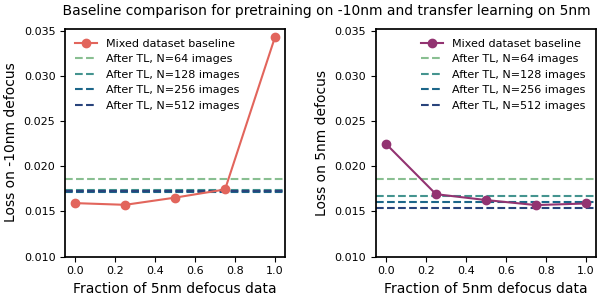

In [10]:
# | label: app:baseline_widget


def get_plot_data(
    baseline_df, major_df, minor_df, weight_mode, reduction_mode, N_tl_points, lr, tl_lr
):
    swap_order = major_df > minor_df
    if swap_order:
        major_df, minor_df = minor_df, major_df

    r_baseline_df = baseline_df.query(f"lr=={lr} and major=={major_df} and minor=={minor_df}")

    perf_major = []
    perf_minor = []
    for N_major in (384, 256, 128):
        rr_bdf = r_baseline_df.query(f"N_major == {N_major}")
        perf_major.append(reduction(rr_bdf["baseline_major_perf"], reduction_mode))
        perf_minor.append(reduction(rr_bdf["baseline_minor_perf"], reduction_mode))

    r_df_major = df.query(f"pretrain_lr=={lr} and pretrain_defocus=={major_df}")
    r_df_minor = df.query(f"pretrain_lr=={lr} and pretrain_defocus=={minor_df}")

    perf_minor.reverse()

    perf_major = (
        [reduction(r_df_major[f"best_pretrain_val_{major_df}"], reduction_mode)]
        + perf_major
        + [reduction(r_df_minor[f"best_pretrain_val_{major_df}"], reduction_mode)]
    )
    
    perf_minor = (
        [reduction(r_df_minor[f"best_pretrain_val_{minor_df}"], reduction_mode)]
        + perf_minor
        + [reduction(r_df_major[f"best_pretrain_val_{minor_df}"], reduction_mode)]
    )

    perf_minor.reverse()

    if swap_order:
        perf_major, perf_minor = perf_minor, perf_major

        tl_df_major = r_df_minor.query(
            f"transfer_lr=={tl_lr} and transfer_defocus == {major_df} and freeze_option in {weight_mode}"
        )
    else:
        tl_df_major = r_df_major.query(
            f"transfer_lr=={tl_lr} and transfer_defocus == {minor_df} and freeze_option in {weight_mode}"
        )

    minor_perf_after_tl = [
        (
            N,
            reduction(
                tl_df_major.query(f"N_tl_training_points=={N}")["best_target_transfer_performance"],
                reduction_mode,
            ),
        )
        for N in N_tl_points
    ]
    
    major_perf_after_tl = [
        (
            N,
            reduction(
                tl_df_major.query(f"N_tl_training_points=={N}")[f"best_transfer_performance_{major_df}"],
                reduction_mode,
            ),
        )
        for N in N_tl_points
    ]

    if swap_order:
        perf_major.reverse()
        perf_minor.reverse()
        return perf_minor, perf_major, minor_perf_after_tl, major_perf_after_tl
    else:
        return perf_major, perf_minor, minor_perf_after_tl, major_perf_after_tl





dpi = 100
width = 600 / dpi
height = 300 / dpi
fig_style = {
    "figsize": (width, height),  # inches
    "constrained_layout": True,
    "dpi":dpi
}

### Get plot data
fig = plt.figure(**fig_style)
gs = fig.add_gridspec(1, 2, wspace=0.1)
ax_pt = fig.add_subplot(gs[0])
ax_tl = fig.add_subplot(gs[1])
pretrain_cmap = sns.diverging_palette(
    250, 30, l=60, s=100, center="dark", sep=1, as_cmap=True
)  ## for major/minor perf

baseline_palette = sns.color_palette('flare', 9)
### Figure and style set up
Nc = 9
tl_palette = sns.color_palette("crest", Nc)  ## for TL lines
colors = [tl_palette[i] for i in (0, Nc // 3, 2*Nc // 3, Nc - 1)]

style = {
    "marker": "o",
    "linewidth": 1.5,
}

frac = [0, 0.25, 0.5, 0.75, 1.0]

## widgets
major_slider = IntSlider(
    value=-100,
    min=-100,
    max=100,
    step=50,
    # description="Major defocus (nm):",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
    layout={"width": "150px"},
)

minor_slider = IntSlider(
    value=50,
    min=-100,
    max=100,
    step=50,
    # description="Minor defocus (nm):",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
    layout={"width": "150px"},
)

ndata_select = n_image_select()

ptlr_select = Select(
    options=["1e-3", "1e-4"],
    value="1e-4",
    rows=2,
    # description="Pretrain LR",
    disabled=False,
    description_width="initial",
    layout={"width": "100px"},
)
tllr_select = Select(
    options=["1e-4", "1e-5"],
    value="1e-5",
    rows=2,
    # description="Transfer LR",
    disabled=False,
    description_width="initial",
    layout={"width": "100px"},
)
rmode_select = reduction_select()
freeze_select = weight_freezing_select()
# left_box = VBox([major_slider, minor_slider, ndata_select, freeze_select])
# right_box = VBox([rmode_select, ptlr_select, tllr_select])
# widget_box = HBox([left_box, right_box])

center_align = Layout(align_items="center")
ptlr_box = VBox([Label("Pretrain LR"), ptlr_select], layout=center_align)
tllr_box = VBox([Label("Transfer LR"), tllr_select], layout=center_align)
ndata_box = VBox([Label("# of transfer images"), ndata_select], layout=center_align)
freeze_box = VBox([Label("Weight Freezing"), freeze_select], layout=center_align)

left_box = VBox([ndata_box, freeze_box], layout={"align_items": "center", "width": "150px"})
right_box = VBox(
    [
        ptlr_box,
        tllr_box,
    ],
    layout={"align_items": "center", "width": "150px"},
)

slider_box = VBox(
    [
        Label("Major defocus (nm)", style={"font_size": "8pt"}),
        major_slider,
        Label("Minor defocus (nm)", style={"font_size": "8pt"}),
        minor_slider,
    ],
    layout=center_align,
)

rmode_box = VBox(
    [Label("Data reduction"), rmode_select, slider_box],
    layout={"align_items": "center", "width": "170px"},
)
menu_box = HBox([left_box, right_box, rmode_box])



display(menu_box)


# def update_baseline_plot(major_df, minor_df, lr, tl_lr, N_tl_points, reduction_mode):
def update_baseline_plot(*args):
    major_df = major_slider.value
    minor_df = minor_slider.value
    N_tl_points = ndata_select.value
    lr = ptlr_select.value
    tl_lr = tllr_select.value
    reduction_mode = rmode_select.value
    weight_mode = freeze_select.value

    perf_major, perf_minor, minor_perf_after_tl, major_perf_after_tl = get_plot_data(
        baseline_df, major_df, minor_df, weight_mode, reduction_mode, N_tl_points, lr, tl_lr
    )

    for ax in [ax_pt, ax_tl]:
        ax.clear()
        for artist in ax.artists:
            artist.remove()

    ax_pt.plot(frac, perf_major, **style, color=baseline_palette[2], label=f"Mixed dataset baseline")
    ax_tl.plot(frac, perf_minor, **style, color=baseline_palette[-3], label=f"Mixed dataset baseline")

    for i, (n, p) in enumerate(minor_perf_after_tl):
        ax_tl.axhline(
            p,
            linewidth=1.5,
            linestyle="--",
            zorder=-1,
            color=colors[i],
            label=f"After TL, N={n} images",
        )
        
    for i, (n, p) in enumerate(major_perf_after_tl):
        ax_pt.axhline(
            p,
            linewidth=1.5,
            linestyle="--",
            zorder=-1,
            color=colors[i],
            label=f"After TL, N={n} images",
        )
        
    ax_pt.set_ylabel(f"Loss on {major_df // 10}nm defocus")
    ax_tl.set_ylabel(f"Loss on {minor_df // 10}nm defocus")

    max_yl = max(ax_pt.get_ylim()[1], ax_tl.get_ylim()[1])
    for ax in [ax_pt, ax_tl]:
        ax.set_xlabel(f"Fraction of {minor_df // 10}nm defocus data")
        ax.legend(frameon=False, fontsize=8)
        ax.set_ylim(0.01, max_yl)
        _ = plt.setp(ax.spines.values(), linewidth=1.25)

    fig.suptitle(f'            Baseline comparison for pretraining on {major_df//10}nm and transfer learning on {minor_df//10}nm', fontsize=10)


### Interactive settings
major_df = -100  # Slider
minor_df = 50  # Slider
lr = 1e-4  # Filter select
tl_lr = 1e-5  # filter select
N_tl_points = (128, 256, 512)  # Filter select
reduction_mode = "median"  # Drop down

# update_baseline_plot(major_df, minor_df, lr, tl_lr, N_tl_points, reduction_mode)
update_baseline_plot()
major_slider.observe(update_baseline_plot, "value")
minor_slider.observe(update_baseline_plot, "value")
ndata_select.observe(update_baseline_plot, "value")
ptlr_select.observe(update_baseline_plot, "value")
tllr_select.observe(update_baseline_plot, "value")
rmode_select.observe(update_baseline_plot, "value")
freeze_select.observe(update_baseline_plot, "value")

# update_baseline_plot()
### Formatting